<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd  # לעבודה עם נתונים טבלאיים
import matplotlib.pyplot as plt  # להצגת גרפים
import seaborn as sns
import os
import zipfile
from matplotlib import rcParams



In [2]:

# הורדת הנתונים מה-GitHub
!git clone https://github.com/orifelszer/CrimeData.git

# הגדרת התיקייה לאחר ההורדה
zip_folder = 'CrimeData'

# הגדרת נתיבים ישירים לשני הקבצים
zip_files = [
    os.path.join(zip_folder, 'Clean_data_unsupervised_part1.zip'),
    os.path.join(zip_folder, 'Clean_data_unsupervised_part2.zip')
]

# רשימה לשמירת נתיבי הקבצים שנפרסו
extracted_folders = []

# פריסת קבצי ה-ZIP
for zip_file in zip_files:
    extract_path = zip_file.replace('.zip', '')  # יצירת שם תיקייה לפי שם הקובץ

    # בדיקה אם הקובץ קיים
    if os.path.exists(zip_file):
        # בדיקה אם התיקייה כבר נפרסה
        if not os.path.exists(extract_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted: {zip_file} -> {extract_path}")
        else:
            print(f"Skipped: {zip_file} (Already extracted)")
    else:
        print(f"File not found: {zip_file}")

    extracted_folders.append(extract_path)

# איחוד קבצי CSV שפורסו
dataframes = []

for folder in extracted_folders:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.csv'):
            df_temp = pd.read_csv(file_path)
            dataframes.append(df_temp)

# איחוד כל הנתונים למסגרת נתונים אחת
combined_df = pd.concat(dataframes, ignore_index=True)

# הצגת מסגרת הנתונים המאוחדת
print(f"Combined dataset contains {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")

Cloning into 'CrimeData'...
remote: Enumerating objects: 973, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 973 (delta 228), reused 146 (delta 146), pack-reused 682 (from 2)
Receiving objects: 100% (973/973), 300.98 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (514/514), done.
Extracted: CrimeData/Clean_data_unsupervised_part1.zip -> CrimeData/Clean_data_unsupervised_part1
Extracted: CrimeData/Clean_data_unsupervised_part2.zip -> CrimeData/Clean_data_unsupervised_part2
Combined dataset contains 1686927 rows and 19 columns.


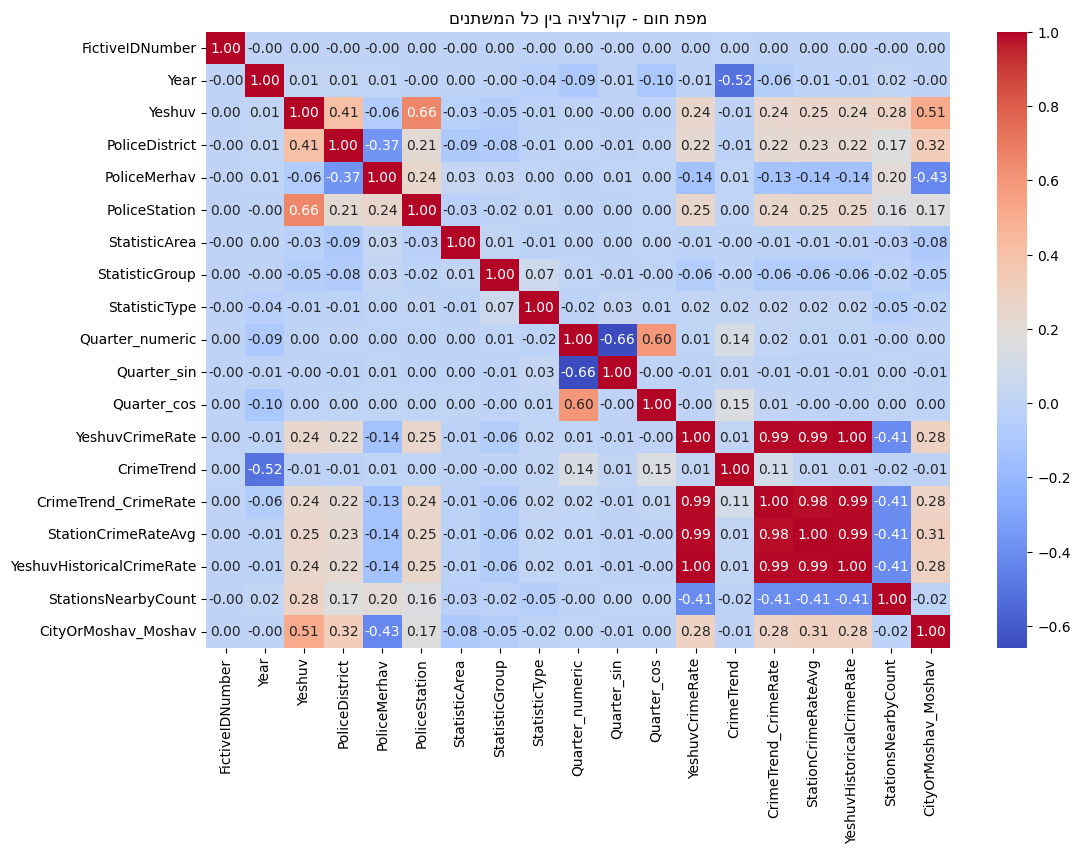

In [4]:
# Reverse Hebrew text (if necessary) for axis labels
def reverse_hebrew_text(text):
    return text[::-1] if isinstance(text, str) else text  # Reverse strings only

# חישוב מטריצת הקורלציה עבור כל המשתנים המספריים
correlation_matrix = combined_df.corr()

# יצירת גרף Heatmap להצגת הקורלציות
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(reverse_hebrew_text("מפת חום - קורלציה בין כל המשתנים"))
plt.show()


*   By looking at the matrix we can see that our primary variable of interest is YeshuvCrimeRate, as it measures the average crime rate in each locality.
*   CrimeTrend was chosen due to its strong positive correlation with YeshuvCrimeRate.
*   StationsNearbyCount was included due to its moderate negative correlation with YeshuvCrimeRate, reflecting the influence of nearby police resources.




In [5]:
# Grouping by 'Yeshuv' to calculate metrics
yeshuv_grouped = combined_df.groupby('Yeshuv').agg(
    YeshuvCrimeRateAvg=('YeshuvCrimeRate', 'mean'),
    StationsNearbyAvg=('StationsNearbyCount', 'mean'),
    CrimeTrendAvg=('CrimeTrend', 'mean')).reset_index()


#To make fair comparisons across localities, we normalized the crime rate by dividing it by the average number of nearby stations
yeshuv_grouped['CrimeRateNormalized'] = (
    yeshuv_grouped['YeshuvCrimeRateAvg'] / yeshuv_grouped['StationsNearbyAvg'])

In [6]:
# מיון היישובים לפי פשיעה יורדת ומספר תחנות עולה
sorted_yeshuv = yeshuv_grouped.sort_values(by=['YeshuvCrimeRateAvg', 'StationsNearbyAvg'], ascending=[False, True])

# הצגת עשרת היישובים המובילים בפשיעה גבוהה ומעט תחנות
print("10 היישובים הבעייתיים ביותר לפי פשיעה ומספר תחנות:")
print(sorted_yeshuv.head(10))


10 היישובים הבעייתיים ביותר לפי פשיעה ומספר תחנות:
    Yeshuv  YeshuvCrimeRateAvg  StationsNearbyAvg  CrimeTrendAvg  \
80      80            2.490922           3.500010       4.646094   
33      33            2.364671           1.998603       4.761460   
8        8            1.184634           3.500010       4.706782   
25      25            0.975553           3.000010       4.702239   
70      70            0.625726           4.500010       4.627364   
57      57            0.617891           4.499673       4.651610   
50      50            0.596563           4.500010       4.657544   
6        6            0.523885           3.500010       4.687727   
24      24            0.487452           3.500246       4.597544   
14      14            0.485299           3.502782       4.630808   

    CrimeRateNormalized  
80             0.711690  
33             1.183162  
8              0.338466  
25             0.325183  
70             0.139050  
57             0.137319  
50             0.1

In [7]:
# Define thresholds for high crime rate and low station count
high_crime_threshold = yeshuv_grouped['YeshuvCrimeRateAvg'].mean()
low_station_threshold = yeshuv_grouped['StationsNearbyAvg'].mean()

# Filter priority localities
priority_yeshuvs = yeshuv_grouped[
    (yeshuv_grouped['YeshuvCrimeRateAvg'] > high_crime_threshold) &
    (yeshuv_grouped['StationsNearbyAvg'] < low_station_threshold)]

### Identifying Priority Localities

To identify areas that need urgent attention, we applied the following criteria:

1. **High Crime Rate Threshold**:
   - We calculated the mean of the average crime rates (`YeshuvCrimeRateAvg`) across all localities.
   - Localities with crime rates higher than this mean are flagged as having high crime severity.

2. **Low Station Count Threshold**:
   - We calculated the mean of the average number of nearby stations (`StationsNearbyAvg`) across all localities.
   - Localities with fewer nearby stations than this mean are flagged as under-resourced.

3. **Filtering Priority Localities**:
   - We selected localities that meet both conditions:
     - `YeshuvCrimeRateAvg > high_crime_threshold`
     - `StationsNearbyAvg < low_station_threshold`

This approach identifies "priority localities" that experience disproportionately high crime rates despite limited resources. These areas can be targeted for further investigation, resource allocation, or policy adjustments.


In [8]:
# הורדת קובץ המיפוי מה-GitHub
mapping_file_path = os.path.join(zip_folder, 'Yeshuv_mapping_unsupervised.csv')
if os.path.exists(mapping_file_path):
    mapping_data = pd.read_csv(mapping_file_path)
else:
    raise FileNotFoundError(f"Mapping file not found at {mapping_file_path}")

In [9]:
# Merge with mapping data to get locality names
priority_yeshuvs_with_names = pd.merge(
    priority_yeshuvs,
    mapping_data,
    left_on='Yeshuv',
    right_on='Encoded_Value',
    how='left')

In [10]:
# Correct selection of columns ensuring all are present
priority_yeshuvs_with_names = priority_yeshuvs_with_names[[ 'YeshuvCrimeRateAvg', 'StationsNearbyAvg', 'CrimeTrendAvg', 'CrimeRateNormalized', 'Encoded_Value', 'Yeshuv_y'
]].rename(columns={'Yeshuv_y': 'Locality_Name'})

In [11]:
priority_yeshuvs_with_names

,YeshuvCrimeRateAvg,StationsNearbyAvg,CrimeTrendAvg,CrimeRateNormalized,Encoded_Value,Locality_Name
0,0.310474,3.000010,4.674427,0.103491,23,חדרה
1,0.975553,3.000010,4.702239,0.325183,25,חיפה
2,2.364671,1.998603,4.761460,1.183162,33,ירושלים
3,0.239784,3.000010,4.675715,0.079928,52,עכו


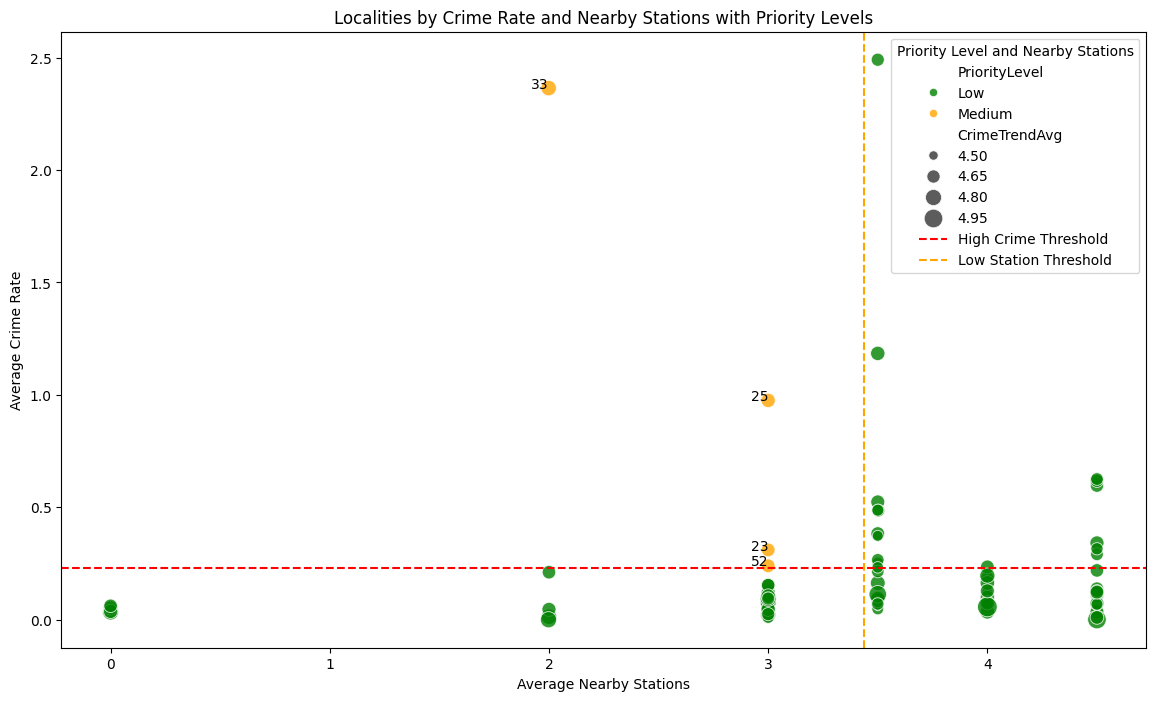

In [12]:
# Define thresholds
high_trend_threshold = yeshuv_grouped['CrimeTrendAvg'].mean()  # You can use mean, median, or another measure

# Create a copy of the data with priority level assignment
yeshuv_grouped['PriorityLevel'] = 'Low'
yeshuv_grouped.loc[
    (yeshuv_grouped['YeshuvCrimeRateAvg'] > high_crime_threshold) &
    (yeshuv_grouped['StationsNearbyAvg'] < low_station_threshold) &
    (yeshuv_grouped['CrimeTrendAvg'] > high_trend_threshold),
    'PriorityLevel'
] = 'High'

yeshuv_grouped.loc[
    (yeshuv_grouped['YeshuvCrimeRateAvg'] > high_crime_threshold) &
    (yeshuv_grouped['StationsNearbyAvg'] < low_station_threshold),
    'PriorityLevel'
] = 'Medium'

# Define colors for priority levels
priority_colors = {
    'High': 'red',
    'Medium': 'orange',
    'Low': 'green'
}

# Scatterplot with priority levels
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x=yeshuv_grouped['StationsNearbyAvg'],
    y=yeshuv_grouped['YeshuvCrimeRateAvg'],
    hue=yeshuv_grouped['PriorityLevel'],
    size=yeshuv_grouped['CrimeTrendAvg'],
    sizes=(20, 200),
    palette=priority_colors,
    alpha=0.8
)

# Add threshold lines
plt.axhline(high_crime_threshold, color='red', linestyle='--', label='High Crime Threshold')
plt.axvline(low_station_threshold, color='orange', linestyle='--', label='Low Station Threshold')

# Add locality names to points with high/medium priority
for index, row in yeshuv_grouped.iterrows():
    if row['PriorityLevel'] in ['High', 'Medium']:
        # Apply reverse_hebrew_text to the actual value of Yeshuv_y
        plt.text(row['StationsNearbyAvg'], row['YeshuvCrimeRateAvg'], reverse_hebrew_text(row['Yeshuv']),
                 fontsize=10, ha='right')


# Titles and labels
plt.title("Localities by Crime Rate and Nearby Stations with Priority Levels")
plt.xlabel("Average Nearby Stations")
plt.ylabel("Average Crime Rate")
plt.legend(title="Priority Level and Nearby Stations")
plt.show()



Yellow dots are flagged as high-priority targets for increasing police station coverage or other interventions to reduce crime.
We're continuing our analysis focusing in these localities.

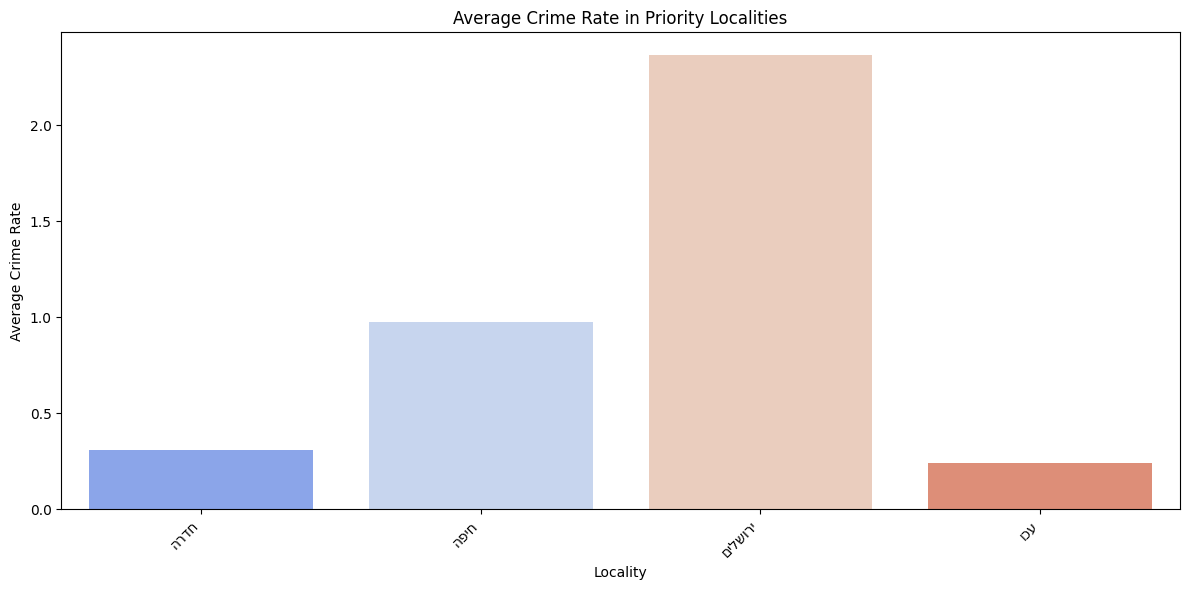

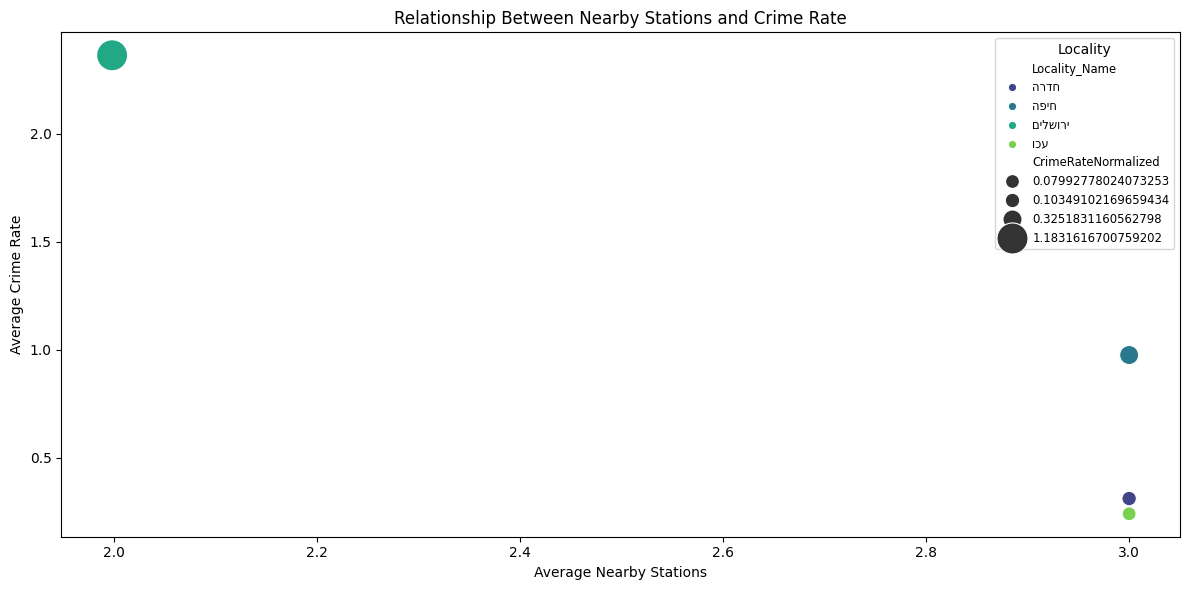

In [22]:
# Ensure RTL support in matplotlib
rcParams['text.usetex'] = False  # Disable LaTeX for better compatibility
rcParams['font.family'] = 'DejaVu Sans'  # Use a font that supports Hebrew characters

# Reverse Hebrew text for 'Locality_Name'
priority_yeshuvs_with_names['Locality_Name'] = priority_yeshuvs_with_names['Locality_Name'].apply(reverse_hebrew_text)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=priority_yeshuvs_with_names,
    x='Locality_Name',
    y='YeshuvCrimeRateAvg',
    hue='Locality_Name',  # Explicitly assign x to hue
    palette='coolwarm',
    dodge=False  # Avoid multiple bars for same x-value
)
plt.title("Average Crime Rate in Priority Localities", loc='center')
plt.xlabel("Locality")
plt.ylabel("Average Crime Rate")
plt.xticks(rotation=45, horizontalalignment='right')
plt.legend([], [], frameon=False)  # Hide legend if unnecessary
plt.tight_layout()
plt.show()

# Visualization: Scatterplot showing relationship between stations and crime rates with RTL text
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=priority_yeshuvs_with_names,
    x='StationsNearbyAvg',
    y='YeshuvCrimeRateAvg',
    size='CrimeRateNormalized',
    hue='Locality_Name',
    sizes=(100, 500),
    palette='viridis'
)
# Add legend explicitly for scatterplot
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, labels, title="Locality", loc='best', fontsize='small')
plt.title("Relationship Between Nearby Stations and Crime Rate", loc='center')
plt.xlabel("Average Nearby Stations")
plt.ylabel("Average Crime Rate")
plt.tight_layout()
plt.show()



Jerusalem (ירושלים ) appears to be an outlier with a disproportionately high crime rate and fewer stations nearby, which might warrant further investigation or additional resources.
Haifa (חיפה) and Hadera (חדרה ) have higher numbers of nearby stations, which may contribute to their lower crime rates.

### Visual Comparison of Anomaly Detection Methods

We visually compare the results of two anomaly detection methods — **Isolation Forest** and **Local Outlier Factor (LOF)** — using scatterplots:

1. **Isolation Forest**:
   - Flags anomalies (red points) and normal observations (blue points) based on patterns in `Average Nearby Stations` and `Average Crime Rate`.
   - The results are based on the anomaly scores calculated during model training.

2. **Local Outlier Factor (LOF)**:
   - Flags anomalies (orange points) and normal observations (green points) using a nearest-neighbor approach to measure local deviation.
   - LOF assigns anomaly scores based on how isolated a point is relative to its neighbors.

**Key Observations**:
- Both methods aim to identify points that deviate significantly from the norm.
- Comparing the visualizations helps evaluate which method aligns better with domain knowledge.

**Next Steps**:
- Investigate flagged anomalies to validate their correctness.
- Consider using additional metrics (e.g., precision, recall) to evaluate the methods quantitatively.


In [17]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest model
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
priority_yeshuvs_with_names['Anomaly'] = isolation_forest.fit_predict(
    priority_yeshuvs_with_names[['YeshuvCrimeRateAvg', 'StationsNearbyAvg']]
)


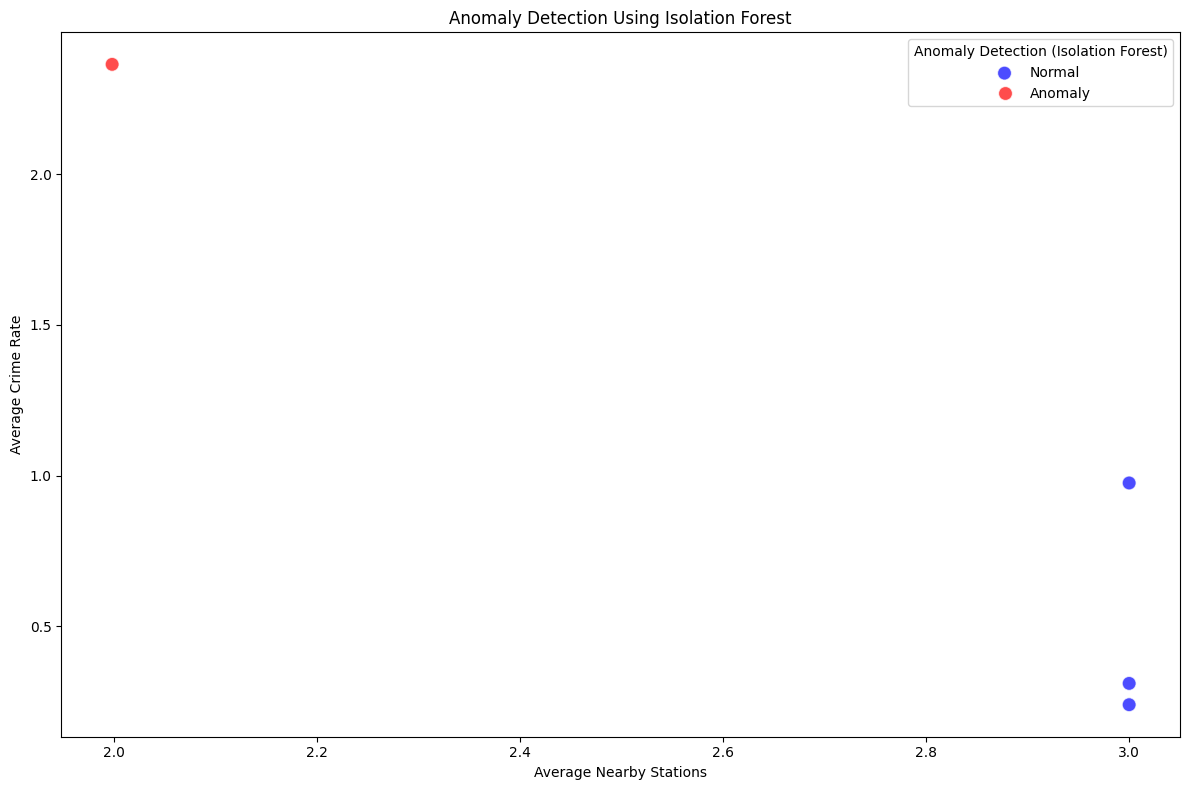

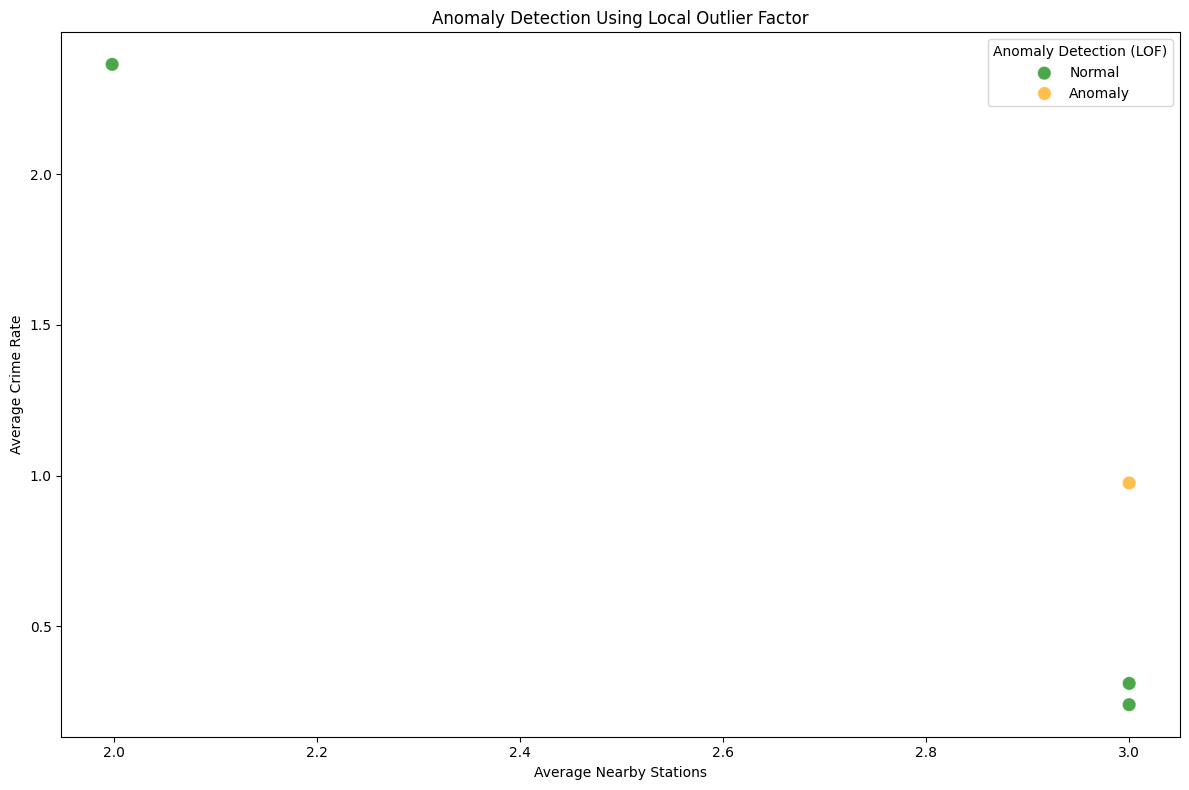

In [18]:
# Set font for Hebrew compatibility
plt.rcParams['font.family'] = 'DejaVu Sans'

# ====== Step 1: Anomaly Detection with Isolation Forest ======
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=priority_yeshuvs_with_names['StationsNearbyAvg'],
    y=priority_yeshuvs_with_names['YeshuvCrimeRateAvg'],
    hue=priority_yeshuvs_with_names['Anomaly'],  # -1 for anomalies, 1 for normal
    palette={-1: 'red', 1: 'blue'},
    s=100,
    alpha=0.7
)

plt.title("Anomaly Detection Using Isolation Forest")
plt.xlabel("Average Nearby Stations")
plt.ylabel("Average Crime Rate")
plt.legend(title="Anomaly Detection (Isolation Forest)", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.show()

# ====== Step 2: Anomaly Detection with LOF ======
from sklearn.neighbors import LocalOutlierFactor

# Dynamically adjust n_neighbors based on dataset size
n_neighbors = min(20, len(priority_yeshuvs_with_names) - 1)

# Train LOF model
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
priority_yeshuvs_with_names['Anomaly_LOF'] = lof.fit_predict(
    priority_yeshuvs_with_names[['YeshuvCrimeRateAvg', 'StationsNearbyAvg']]
)

# Scatterplot for LOF
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=priority_yeshuvs_with_names['StationsNearbyAvg'],
    y=priority_yeshuvs_with_names['YeshuvCrimeRateAvg'],
    hue=priority_yeshuvs_with_names['Anomaly_LOF'],  # -1 for anomalies, 1 for normal
    palette={-1: 'orange', 1: 'green'},
    s=100,
    alpha=0.7
)

plt.title("Anomaly Detection Using Local Outlier Factor")
plt.xlabel("Average Nearby Stations")
plt.ylabel("Average Crime Rate")
plt.legend(title="Anomaly Detection (LOF)", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.show()



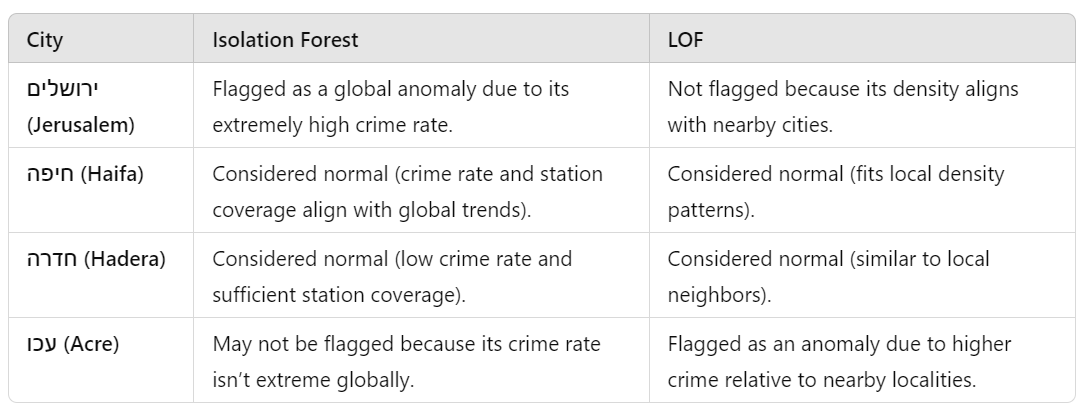

We initially hypothesized that the high crime rates in Jerusalem and Acre might be linked to their status as mixed cities with diverse populations. However, this was dismissed, as Haifa, a well-known mixed city, does not show similar crime patterns. The anomalies in Jerusalem and Acre may instead stem from their lower number of police stations or the inefficiency of these stations in addressing local crime.


**Insights and Recommendations**

Jerusalem (ירושלים):

Identified as a global anomaly by *Isolation Forest* due to its extremely high crime rate  despite moderate police station coverage.
Recommendation: Increase police resources and station coverage in the area; and conduct a deeper investigation to identify underlying causes of the high crime rate.

Acre (עכו):

Flagged as a local anomaly by *LOF*  for having a higher crime rate  than nearby localities with similar police station coverage .
Recommendation: Evaluate police station effectiveness and explore socio-economic factors contributing to crime.

Haifa (חיפה) and Hadera (חדרה):

Both classified as normal by both algorithms, with low crime rates and adequate station coverage.
Recommendation: These cities do not require immediate action as they align with global and local patterns. Continue monitoring these localities to ensure they remain stable.